In [297]:
import pandas as pd
df = pd.read_excel("/Users/tomhaidinger/Desktop/outputDataHelvetas.xlsx")

#new_header = df.iloc[0]
#df = df[1:]
#df.columns = new_header
#df.info()
#df2 = df.loc[0:1163,'Description']

In [298]:
#df1 = df.loc[1:11, "Description"]
df1 = df.loc[0:1163, 'Description']

df1

0       ['project', 'agricultural', 'actor', 'differ', 'profa', 'strategic', 'orientation', 'focus', 'co...
1       ['bio', 'project', 'cotton', 'organic', 'fair', 'trade', 'crop', 'protect', 'area', 'follow', 'p...
2       ['support', 'vocational', 'training', 'afp', 'project', 'part', 'logic', 'development', 'local',...
3       ['project', 'drink', 'water', 'school', 'health', 'center', 'project', 'fund', 'financing', 'hel...
4       ['intervention', 'qualieau', 'program', 'follow', 'improvement', 'water', 'sanitation', 'service...
                                                       ...                                                 
1159    ['health', 'provide', 'support', 'create', 'newsletter', 'mantain', 'sharepoint', 'web', 'base',...
1160    ['agriculture', 'food', 'security', 'provide', 'support', 'create', 'newsletter', 'mantain', 'sh...
1161    ['agriculture', 'food', 'security', 'provide', 'support', 'create', 'newsletter', 'mantain', 'sh...
1162    ['objective', 'overa

In [299]:
import nltk; nltk.download('stopwords');

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tomhaidinger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [300]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim # pip install -U gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy   # pip install -U spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # pip install -U pyLDAvis.gensim_models
import matplotlib.pyplot as plt
#matplotlib inline

In [301]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])
                   #'project', 'projects', 'improve', 'increase', 'support', 'management', 'development'])

In [260]:
#data = ['The project supports understanding and conservation of local sites that are '
# 'of cultural and historical interest through archaeology. The involvement of '
# 'communities in these processes is promoted for ownership as resource persons '
# 'and for sustainable management of sites that are excavated. The wider '
# 'implication is that it leads to strengthening of community roles and '
# 'responsibilities over local heritage and local development.The documentation '
# 'of archaeological findings and their professional presentation will also '
# 'lead to economic benefits for rural communities. It is expected that doors '
# 'will open to new sources of income through well thought through sustainable '
# 'tourism. The archaeological works are carried out jointly by experts from '
# 'Switzerland and partners in Bhutan so that knowledge and skill transfers '
# 'take place. The increased interest and capacities in archaeology in the '
# 'partner department and among culture officers in partner districts are '
# 'concrete outputs.']
#print(test_string)

In [302]:
#data = df1.to_numpy().tolist()
data = df1
data = [re.sub("\\s*,\\s*", ' ', sent) for sent in data] ## removes commas
#data = [re.sub("\\.", " ", sent) for sent in data] ## removes full stops / nvm dont employ


data = [re.sub("\\s+", ' ', sent) for sent in data] ## removes new line charaters
data = [re.sub("'", "", sent) for sent in data] ## removes single qoutations

#pprint(data[:1])

In [303]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['project', 'agricultural', 'actor', 'differ', 'profa', 'strategic', 'orientation', 'focus', 'component', 'certification', 'participatory', 'guarantee', 'system', 'spg', 'governance', 'agricultural', 'sector', 'lever', 'well', 'actor', 'remain', 'essential', 'survival', 'family', 'farming', 'thus', 'cover', 'period', 'period', 'year', 'project', 'intervention', 'area', 'cover', 'first', 'area', 'market', 'garden', 'second', 'axis', 'colline', 'department', 'work', 'agricultural', 'orientation', 'law', 'synpa', 'land', 'coproama', 'company', 'csft', 'promo', 'fruit', 'et', 'fruit', 'tillou', 'pineapple', 'derivative']]


In [304]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100) 

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [305]:
print(trigram_mod[bigram_mod[data_words[0]]])

['project', 'agricultural', 'actor', 'differ', 'profa', 'strategic', 'orientation', 'focus', 'component', 'certification', 'participatory', 'guarantee', 'system', 'spg', 'governance', 'agricultural', 'sector', 'lever', 'well', 'actor', 'remain', 'essential', 'survival', 'family', 'farming', 'thus', 'cover', 'period', 'period', 'year', 'project', 'intervention', 'area', 'cover', 'first', 'area', 'market', 'garden', 'second', 'axis', 'colline', 'department', 'work', 'agricultural', 'orientation', 'law', 'synpa', 'land', 'coproama', 'company', 'csft', 'promo', 'fruit', 'et', 'fruit', 'tillou', 'pineapple', 'derivative']


In [306]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [307]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)
#print(data_words_nostops[:1])

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)  
#print(data_words_bigrams[:1])

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[0])

['project', 'agricultural', 'actor', 'differ', 'profa', 'strategic', 'orientation', 'focus', 'component', 'certification', 'participatory', 'guarantee', 'system', 'spg', 'governance', 'agricultural', 'sector', 'lever', 'actor', 'remain', 'essential', 'survival', 'family', 'farming', 'thus', 'cover', 'period', 'period', 'year', 'project', 'intervention', 'area', 'cover', 'first', 'area', 'market', 'garden', 'second', 'axis', 'colline', 'department', 'work', 'agricultural', 'orientation', 'law', 'synpa', 'company', 'csft', 'promo', 'fruit', 'et', 'fruit', 'tillou', 'pineapple', 'derivative']


In [341]:
# Imports necessary modules
import nltk
import spacy
from gensim.models.phrases import Phraser, Phrases
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from typing import Iterable

# Imports generic stopwords
nltk.download('stopwords')


class Standardizer:
    def __init__(self):
        self.nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
        self.stop_words = stopwords.words('english')
        self.stop_words.extend(['from', 'subject', 're', 'edu', 'use']) 
        # possible extra stopwords 'project', 'projects', 'support', 'increase', 'improve'])
        # CAUTION: with extra stopwords above topic coherence signifcatnly deceases
        
    def add_stopwords(self, add_stop_words: Iterable[str]):
        self.stop_words.extend(add_stop_words)
        
    def strings2words(self, strings):
        # FIXME Make use of generator later. Returned empty list generator was used. Unknown reason.
        return [simple_preprocess(string, deacc=True) for string in strings] 
        
    def remove_stopwords(self, tokens_with_stopwords: Iterable[Iterable[str]]):   
        retList = []
        for tokenList in tokens_with_stopwords:
            retList.append(
                [token for token in simple_preprocess(str(tokenList)) if token not in self.stop_words])
        return retList
        
    def lemmatization(self, texts, nlp, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
        """https://spacy.io/api/annotation"""
        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent))
            texts_out.append(
                [token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out
        
    def standardize(self, raw_strings: Iterable[str], nlp) -> Iterable[Iterable[str]]:
        """Standardize an Iterable of strings.
        Remove stop words, punctuation, new line characters, and lemmatize each word.
    
        Args:
            text (Iterable[str]): Strings to process.
            nlp: Spacy NLP object.
    
        Returns:
            Iterable[Iterable[str]]: Processed list of tokens for each input string.
        """
    
        print("Standardizing...")
    
        # convert each strings to an iterable of contained words
        doc_words = self.strings2words(raw_strings)
    
        # Build the bigram and trigram models
        # higher threshold fewer phrases.
        bigram = Phrases(doc_words, min_count=5, threshold=100)
        # Faster way to get a sentence clubbed as a trigram/bigram
        bigram_mod = Phraser(bigram)
    
        # Remove Stop Words
        nonstop_doc_words = self.remove_stopwords(doc_words)
    
        # Form Bigramss
        data_words_bigrams = [bigram_mod[tokens] for tokens in nonstop_doc_words]
    
        # Do lemmatization keeping only noun, adj, vb, adv
        data_lemmatized = self.lemmatization(data_words_bigrams, self.nlp)
        return data_lemmatized


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tomhaidinger/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [342]:
import pandas as pd
#lemmaDF = pd.DataFrame()
#lemmaDF["Description"] = ['[ string string String in predict','bling bling bling me ','go go go improve']


df = pd.read_excel("/Users/tomhaidinger/Desktop/outputDataHelvetas.xlsx")
lemmaDF1 = df.loc[0:1163, "Description"]


import spacy
#nlp = spacy.load("en_core_web_lg")

In [343]:
std = Standardizer()

In [344]:
data_words_class = std.strings2words(lemmaDF1)


In [345]:
data_words = list(sent_to_words(lemmaDF1))

In [346]:
data_words == data_words_class

True

In [347]:
special_data = std.standardize(lemmaDF1, nlp)

Standardizing...


In [348]:
data_lemmatized[0] == special_data[0]

True

In [349]:
#set(data_lemmatized)-set(special_data)
a = 0
for i in range(len(data_lemmatized)):
    a = a + len([x for x in data_lemmatized[i] if x not in special_data[i]])
    
print(a)

0


In [350]:
#set(data_lemmatized)-set(special_data)
b = 0
for i in range(len(data_lemmatized)):
    b = b + len(data_lemmatized[i])
    
print(b)

76809


In [311]:
 special_data[0]

['project',
 'agricultural',
 'actor',
 'differ',
 'profa',
 'strategic',
 'orientation',
 'focus',
 'component',
 'certification',
 'participatory',
 'guarantee',
 'system',
 'spg',
 'governance',
 'agricultural',
 'sector',
 'lever',
 'well',
 'actor',
 'remain',
 'essential',
 'survival',
 'family',
 'farming',
 'thus',
 'cover',
 'period',
 'period',
 'year',
 'project',
 'intervention',
 'area',
 'cover',
 'first',
 'area',
 'market',
 'garden',
 'second',
 'work',
 'agricultural',
 'orientation',
 'law',
 'synpa',
 'company',
 'csft',
 'promo',
 'fruit',
 'et',
 'fruit',
 'tillou',
 'pineapple',
 'derivative']

In [281]:
#data_lemmatized = df1

# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized) ### NOT ['Description'] for return  from preprocessing

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#print(corpus[2])
print(corpus[0])

[(0, 2), (1, 3), (2, 2), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 2), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 2), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 1), (29, 2), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1)]


In [282]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('actor', 2),
  ('agricultural', 3),
  ('area', 2),
  ('axis', 1),
  ('certification', 1),
  ('colline', 1),
  ('company', 1),
  ('component', 1),
  ('cover', 2),
  ('csft', 1),
  ('department', 1),
  ('derivative', 1),
  ('differ', 1),
  ('essential', 1),
  ('et', 1),
  ('family', 1),
  ('farming', 1),
  ('first', 1),
  ('focus', 1),
  ('fruit', 2),
  ('garden', 1),
  ('governance', 1),
  ('guarantee', 1),
  ('intervention', 1),
  ('law', 1),
  ('lever', 1),
  ('market', 1),
  ('orientation', 2),
  ('participatory', 1),
  ('period', 2),
  ('pineapple', 1),
  ('profa', 1),
  ('project', 2),
  ('promo', 1),
  ('remain', 1),
  ('second', 1),
  ('sector', 1),
  ('spg', 1),
  ('strategic', 1),
  ('survival', 1),
  ('synpa', 1),
  ('system', 1),
  ('thus', 1),
  ('tillou', 1),
  ('work', 1),
  ('year', 1)]]

In [283]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics = 10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [284]:
# Print the Keyword in the x topics
#print(len(lda_model.print_topics()))
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

wp = lda_model.show_topic(3)
#print(wp)

[(0,
  '0.028*"food" + 0.025*"population" + 0.023*"security" + 0.022*"service" + '
  '0.020*"rural" + 0.020*"management" + 0.019*"project" + 0.019*"sustainable" '
  '+ 0.018*"nutrition" + 0.017*"urban"'),
 (1,
  '0.027*"project" + 0.021*"market" + 0.018*"sector" + 0.017*"development" + '
  '0.017*"increase" + 0.017*"private" + 0.016*"improve" + 0.014*"value" + '
  '0.013*"business" + 0.013*"chain"'),
 (2,
  '0.034*"climate" + 0.024*"change" + 0.015*"vulnerable" + 0.015*"community" + '
  '0.015*"risk" + 0.013*"increase" + 0.012*"resilient" + 0.011*"project" + '
  '0.011*"disaster" + 0.011*"adaptation"'),
 (3,
  '0.035*"support" + 0.017*"technical" + 0.017*"mandate" + 0.017*"project" + '
  '0.017*"communication" + 0.016*"assistance" + 0.014*"lot" + 0.014*"model" + '
  '0.013*"education" + 0.013*"development"'),
 (4,
  '0.027*"local" + 0.020*"support" + 0.018*"capacity" + 0.016*"development" + '
  '0.016*"civil_society" + 0.015*"project" + 0.014*"citizen" + 0.014*"reform" '
  '+ 0.014*"go

In [285]:
#df3= pd.DataFrame()


la = [0] * 10
for i in range(10): la[i] = lda_model.show_topic(i)
    
#df3 = df3.append(pd.Series(la), ignore_index=True)
pprint(la)

[[('food', 0.027701376),
  ('population', 0.025265649),
  ('security', 0.022680769),
  ('service', 0.02192616),
  ('rural', 0.01995629),
  ('management', 0.019704532),
  ('project', 0.019402247),
  ('sustainable', 0.018515907),
  ('nutrition', 0.017710445),
  ('urban', 0.01673157)],
 [('project', 0.026554124),
  ('market', 0.02060389),
  ('sector', 0.018342096),
  ('development', 0.017301735),
  ('increase', 0.016997173),
  ('private', 0.016555788),
  ('improve', 0.016317336),
  ('value', 0.013560524),
  ('business', 0.013428759),
  ('chain', 0.01277807)],
 [('climate', 0.033912104),
  ('change', 0.023761058),
  ('vulnerable', 0.015423678),
  ('community', 0.015167789),
  ('risk', 0.015048163),
  ('increase', 0.012880506),
  ('resilient', 0.0117874965),
  ('project', 0.011221446),
  ('disaster', 0.011045105),
  ('adaptation', 0.010949715)],
 [('support', 0.034690097),
  ('technical', 0.01716703),
  ('mandate', 0.016926717),
  ('project', 0.016515309),
  ('communication', 0.016508307),


In [286]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.8487006095695815

Coherence Score:  0.402570229163414


In [287]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/opt/anaconda3/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.072820 -0.134396       1        1  29.989285
1      0.106936 -0.029124       2        1  21.771816
3      0.198830  0.095542       3        1   7.606332
2     -0.123884 -0.053799       4        1   7.315092
7     -0.055658 -0.190131       5        1   7.062384
4      0.099792 -0.122304       6        1   7.033116
6      0.120093  0.204902       7        1   6.350284
5     -0.035598  0.059764       8        1   5.557184
0     -0.148373  0.071820       9        1   4.675819
9     -0.234957  0.097726      10        1   2.638687, topic_info=           Term        Freq       Total Category  logprob  loglift
181       water  845.000000  845.000000  Default  30.0000  30.0000
151       young  284.000000  284.000000  Default  29.0000  29.0000
199  management  586.000000  586.000000  Default  28.0000  28.0000
322  employment  255.000000  255.000000  Default  27.0000  27.0000
95      support  829.000000  829.000000  Default  26.0000  26.0000
..          ...         ...         ...      ...      ...      ...
268    resource   20.715916  287.441299  Topic10  -4.5833   1.0048
83        phase   19.966435  283.245219  Topic10  -4.6201   0.9826
269    security   17.958280  164.025012  Topic10  -4.7261   1.4229
487  vulnerable   17.832882  159.032230  Topic10  -4.7331   1.4468
249    building   16.675099  105.414875  Topic10  -4.8003   1.7909

[640 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
716       1  0.277182        able
716       4  0.705554        able
955       8  0.898111  accelerate
46        1  0.550631      access
46        2  0.282756      access
...     ...       ...         ...
421       2  0.248573       youth
421       3  0.095286       youth
421       4  0.024857       youth
421       7  0.534432       youth
421       8  0.099429       youth

[1119 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 2, 4, 3, 8, 5, 7, 6, 1, 10])

In [288]:
#DEPTRECIATED
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#mallet_path = '/Users/tomhaidinger/Desktop/mallet-2.0.8/bin/mallet' # update this path
#ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in fav

In [21]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        #print(row) #print to see more
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        print(row)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic if 0
                wp = ldamodel.show_topic(topic_num)
                #print(wp)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
                #print(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]))
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)


[(5, 0.29974005), (7, 0.20148313), (8, 0.15248996), (6, 0.1476274), (1, 0.11075811), (0, 0.06422677)]
[(6, 0.9427895), (2, 0.031344492)]
[(2, 0.4588838), (5, 0.31069562), (6, 0.07409882), (3, 0.06848249), (9, 0.05426628), (1, 0.021729918)]
[(0, 0.8635527), (3, 0.05704689), (1, 0.047272783), (6, 0.010017049)]
[(0, 0.32223052), (4, 0.27670145), (9, 0.21840371), (3, 0.16280608)]
[(2, 0.966886)]
[(2, 0.39703393), (6, 0.16840254), (8, 0.15147297), (7, 0.13097595), (4, 0.08512844), (3, 0.048037402)]
[(5, 0.8026695), (9, 0.17138399)]
[(8, 0.6765633), (5, 0.21556798), (2, 0.07994152)]
[(9, 0.7751119), (0, 0.19678247)]
[(6, 0.6110556), (8, 0.18092625), (9, 0.1421074), (7, 0.032019906), (0, 0.010366643)]
[(1, 0.78800726), (4, 0.17462328)]
[(5, 0.9604429)]
[(0, 0.36768857), (9, 0.26914015), (3, 0.19390158), (7, 0.08549535), (6, 0.05998757), (8, 0.010682615)]
[(3, 0.6660209), (9, 0.23066938), (6, 0.08216463)]
[(8, 0.7014659), (1, 0.16096751), (5, 0.08030001), (0, 0.034915566)]
[(9, 0.38244662), (4

[(1, 0.4445217), (6, 0.27200183), (9, 0.14209288), (7, 0.08762557), (3, 0.022679793), (0, 0.021115609)]
[(2, 0.42147762), (6, 0.2601396), (8, 0.17466427), (9, 0.12780607)]
[(5, 0.6333195), (9, 0.2525494), (1, 0.04038941), (2, 0.036351807), (6, 0.01114881)]
[(2, 0.7109886), (6, 0.18565185), (3, 0.05761221), (5, 0.02721829)]
[(9, 0.5323048), (0, 0.22191358), (2, 0.17715262), (6, 0.019979183), (3, 0.012640044)]
[(9, 0.31691796), (0, 0.2796816), (6, 0.1625817), (7, 0.11504311), (2, 0.05491421), (3, 0.040774874), (4, 0.023570616)]
[(7, 0.73262537), (6, 0.22641034), (1, 0.019706246)]
[(3, 0.48803228), (0, 0.17701057), (6, 0.15848912), (9, 0.08285333), (7, 0.050460435), (5, 0.0296849)]
[(3, 0.86111337), (7, 0.05135842), (1, 0.04351076), (5, 0.020738406)]
[(8, 0.40958983), (6, 0.2779279), (0, 0.10969958), (9, 0.08262835), (7, 0.05278622), (4, 0.045961943)]
[(1, 0.41321316), (0, 0.28157046), (4, 0.19576673), (3, 0.06953087), (8, 0.020947462)]
[(2, 0.6023981), (3, 0.13010171), (8, 0.09740253), (

[(0, 0.6986313), (4, 0.17268722), (3, 0.106073864)]
[(4, 0.91881806), (5, 0.026459064), (3, 0.02535171)]
[(4, 0.9699316)]
[(0, 0.46594277), (4, 0.34704792), (6, 0.12126609), (1, 0.047714688)]
[(2, 0.72656643), (0, 0.24567448)]
[(9, 0.45313683), (6, 0.25783658), (0, 0.14349152), (2, 0.11984989)]
[(2, 0.958389)]
[(0, 0.38888076), (1, 0.28228685), (9, 0.2745481), (6, 0.037880167)]
[(0, 0.49508563), (9, 0.40653774), (1, 0.07195452)]
[(1, 0.379422), (4, 0.23876037), (2, 0.16007066), (0, 0.12528796), (6, 0.07481394)]
[(6, 0.716223), (1, 0.25695783)]
[(4, 0.4948518), (8, 0.15505026), (0, 0.11971785), (7, 0.112206936), (6, 0.05110444), (3, 0.03226161), (5, 0.024448825)]
[(9, 0.74770284), (1, 0.13656543), (3, 0.09286142)]
[(9, 0.3939136), (4, 0.2715032), (0, 0.25180584), (3, 0.05262337), (6, 0.012557317)]
[(9, 0.3206078), (1, 0.14345758), (6, 0.14300355), (7, 0.14074068), (8, 0.11571564), (2, 0.10936128)]
[(0, 0.49004894), (9, 0.38340828), (3, 0.10258226)]
[(0, 0.77704227), (9, 0.19787103)]
[(2

[(6, 0.5736672), (2, 0.20257635), (4, 0.121376485), (8, 0.05237653), (9, 0.032633074)]
[(0, 0.27312225), (7, 0.24476306), (6, 0.24134502), (8, 0.11475047), (9, 0.10984074)]
[(8, 0.49438462), (9, 0.17049827), (1, 0.15692341), (2, 0.08619352), (3, 0.07354665)]
[(6, 0.36136794), (7, 0.29355982), (3, 0.1553987), (4, 0.14162257), (2, 0.02826348)]
[(1, 0.6104655), (0, 0.1335329), (9, 0.09437828), (4, 0.059049174), (2, 0.048820544), (7, 0.037501812)]
[(8, 0.6373615), (9, 0.25146827), (6, 0.06217908), (0, 0.030636055)]
[(0, 0.78387064), (3, 0.09914218), (8, 0.088285245)]
[(9, 0.42344385), (4, 0.21920553), (8, 0.16848673), (6, 0.12041972), (3, 0.05496897)]
[(7, 0.33199337), (1, 0.18523735), (6, 0.15760475), (0, 0.10854388), (4, 0.095799744), (3, 0.041048054), (9, 0.03327612), (8, 0.023453848), (5, 0.020888343)]
[(0, 0.3027096), (2, 0.29800358), (6, 0.17653938), (7, 0.108924374), (3, 0.09071362)]
[(1, 0.33339372), (4, 0.20878957), (8, 0.1412443), (3, 0.1324546), (9, 0.06267106), (2, 0.062015455)

[(1, 0.54123455), (0, 0.30235362), (3, 0.08403779), (4, 0.030167159), (9, 0.02887587)]
[(0, 0.75614977), (8, 0.109212294), (5, 0.06816164), (3, 0.04823144)]
[(0, 0.52871245), (8, 0.20917268), (4, 0.11429315), (3, 0.074358426), (1, 0.051875323)]
[(9, 0.6699108), (0, 0.11986061), (6, 0.08396422), (4, 0.05359829), (1, 0.03787207), (3, 0.026427615)]
[(1, 0.42340744), (9, 0.13908817), (3, 0.10875367), (0, 0.10629497), (4, 0.10569757), (6, 0.09037231), (2, 0.020455133)]
[(9, 0.5227842), (3, 0.16412282), (4, 0.14868876), (6, 0.08928693), (2, 0.035457343), (5, 0.026404338)]
[(3, 0.6913732), (8, 0.16099246), (5, 0.041017), (0, 0.03842844), (4, 0.03689536), (6, 0.022777962)]
[(9, 0.5182694), (1, 0.19958106), (0, 0.10010107), (6, 0.07692226), (3, 0.056585222), (7, 0.03779487)]
[(6, 0.49164307), (8, 0.2846028), (0, 0.11954153), (2, 0.067430384), (7, 0.020725567)]
[(0, 0.43597418), (5, 0.4333168), (8, 0.09016933), (9, 0.022796268)]
[(3, 0.3794596), (9, 0.25402445), (0, 0.2082682), (1, 0.06607159), 

[(5, 0.4670217), (0, 0.18744613), (4, 0.14738141), (9, 0.12685528), (2, 0.046303995)]
[(2, 0.80584735), (6, 0.11773036), (8, 0.052209165)]
[(1, 0.45651096), (6, 0.15469095), (8, 0.10573685), (4, 0.103778146), (9, 0.09982904), (3, 0.03706733), (0, 0.035372946)]
[(4, 0.46252716), (8, 0.23943862), (1, 0.13335952), (7, 0.06299537), (6, 0.046344526), (3, 0.03811605)]
[(2, 0.6980827), (9, 0.117397815), (4, 0.114074215), (6, 0.052068073)]
[(8, 0.46820217), (4, 0.21323146), (5, 0.19173485), (0, 0.10451187)]
[(8, 0.30758908), (0, 0.2030703), (4, 0.19003353), (6, 0.16434011), (7, 0.07282312), (9, 0.050249524)]
[(0, 0.6030509), (3, 0.09315107), (1, 0.073369026), (8, 0.06998679), (2, 0.052014142), (9, 0.039234836), (7, 0.034201875), (4, 0.027580157)]
[(6, 0.9741281)]
[(4, 0.42930788), (6, 0.400305), (0, 0.15284489)]
[(5, 0.608553), (0, 0.12013394), (2, 0.088450685), (6, 0.07242336), (8, 0.05856967), (9, 0.043800782)]
[(4, 0.96993136)]
[(0, 0.4659425), (4, 0.3470481), (6, 0.12126644), (1, 0.0477143

[(0, 0.4992601), (9, 0.2593571), (4, 0.14019836), (1, 0.075918086)]
[(7, 0.60567266), (6, 0.2601911), (3, 0.09368604), (0, 0.024478272)]
[(2, 0.826895), (0, 0.11751024), (4, 0.027962247)]
[(6, 0.91960734), (9, 0.060095076)]
[(6, 0.53284454), (2, 0.1197639), (3, 0.09910313), (0, 0.07613791), (9, 0.07489814), (4, 0.049768116), (1, 0.02532584), (5, 0.018241903)]
[(2, 0.5064476), (6, 0.16766949), (9, 0.12916268), (5, 0.08186704), (7, 0.049626257), (4, 0.047717046)]
[(2, 0.6233273), (6, 0.17827426), (7, 0.11830702), (9, 0.04235185), (1, 0.020553729)]
[(5, 0.5010856), (2, 0.29196417), (9, 0.09964618), (3, 0.06980619), (7, 0.02130299)]
[(4, 0.7150949), (1, 0.11835035), (2, 0.085929155), (0, 0.05477588)]
[(2, 0.6868981), (6, 0.23866479), (3, 0.027672574), (4, 0.025745392)]
[(7, 0.46449465), (6, 0.23297639), (4, 0.09162403), (9, 0.08713176), (0, 0.076679826), (8, 0.03834926)]
[(3, 0.33389774), (1, 0.3158058), (9, 0.2273738), (0, 0.043761585), (7, 0.03741775), (5, 0.026613722)]
[(3, 0.43853617),

[(6, 0.44507706), (2, 0.18797687), (7, 0.11928178), (4, 0.0705987), (3, 0.06568395), (9, 0.05357581), (8, 0.04106411)]
[(7, 0.31750825), (6, 0.26132843), (0, 0.2020496), (4, 0.09940046), (3, 0.046452872), (9, 0.04129557), (2, 0.024539106)]
[(3, 0.41285345), (6, 0.20395832), (2, 0.095847026), (0, 0.09144664), (8, 0.07033928), (1, 0.070236064), (9, 0.046658386)]
[(6, 0.16334875), (0, 0.15099207), (9, 0.1270617), (3, 0.12187641), (4, 0.08716918), (8, 0.08047214), (2, 0.07832568), (1, 0.070244715), (5, 0.06361252), (7, 0.056896836)]
[(3, 0.40402448), (4, 0.1540388), (9, 0.1477682), (0, 0.12479723), (2, 0.0796857), (1, 0.06498031), (6, 0.013765959)]
[(6, 0.5199112), (3, 0.169794), (8, 0.10568232), (2, 0.084209494), (4, 0.044372052), (5, 0.04357813), (0, 0.012001926), (9, 0.010435073)]
[(6, 0.73338443), (9, 0.07344459), (5, 0.06516707), (4, 0.06301434), (0, 0.017867299), (3, 0.014166699)]
[(5, 0.44564697), (9, 0.2698949), (3, 0.09583484), (6, 0.07365377), (1, 0.06605073), (8, 0.032304715)]
[

[(1, 0.45266086), (3, 0.21617392), (0, 0.1500842), (6, 0.09737528), (5, 0.030878955), (9, 0.02599556), (8, 0.020785486)]
[(1, 0.26535603), (0, 0.2554077), (9, 0.15866323), (6, 0.12685396), (3, 0.12464965), (5, 0.058772076)]
[(3, 0.46434844), (1, 0.16828981), (6, 0.14943998), (0, 0.09776663), (5, 0.04020234), (2, 0.039570846), (8, 0.02929557)]
[(3, 0.40412953), (0, 0.3108178), (9, 0.10265919), (7, 0.059074976), (5, 0.052934043), (8, 0.0358623), (2, 0.023746707)]
[(7, 0.2810534), (1, 0.20559458), (9, 0.12807137), (4, 0.11372438), (2, 0.09503942), (3, 0.059303723), (8, 0.04619356), (5, 0.033098612), (6, 0.03151132)]
[(1, 0.1964014), (7, 0.17568304), (4, 0.13926318), (3, 0.11979932), (2, 0.099404864), (6, 0.0935146), (9, 0.09313477), (8, 0.04866482), (5, 0.028023826)]
[(9, 0.72723556), (2, 0.16071014), (6, 0.09374622)]
[(1, 0.76807666), (5, 0.12572329), (4, 0.083194524)]
[(2, 0.29015008), (6, 0.24826977), (5, 0.15225127), (9, 0.13917051), (0, 0.12554216), (3, 0.034829665)]
[(8, 0.55863947)

[(2, 0.6868984), (6, 0.23866129), (3, 0.02767669), (4, 0.025744407)]
[(2, 0.52623415), (5, 0.17116287), (6, 0.10492346), (7, 0.06978113), (0, 0.057570815), (8, 0.031425435), (1, 0.027436245)]
[(7, 0.4644929), (6, 0.2329867), (4, 0.091634504), (9, 0.08712596), (0, 0.076679185), (8, 0.038336758)]
[(3, 0.34260565), (1, 0.2689427), (9, 0.19559821), (5, 0.06560319), (6, 0.057583876), (0, 0.04706686), (7, 0.015714277)]
[(7, 0.35606635), (8, 0.16015612), (6, 0.149852), (1, 0.104322605), (2, 0.10220818), (3, 0.0727754), (9, 0.046162784)]
[(7, 0.36708257), (6, 0.14873047), (8, 0.13330533), (2, 0.105624445), (1, 0.10372103), (3, 0.08767384), (9, 0.045313112)]
[(5, 0.5580651), (9, 0.15770206), (1, 0.13023588), (0, 0.053295955), (4, 0.045617227), (3, 0.043165542)]
[(5, 0.56564456), (0, 0.14915232), (4, 0.14153895), (1, 0.10805959)]
[(9, 0.5463239), (0, 0.4067853), (1, 0.024572855)]
[(6, 0.26310435), (0, 0.20503987), (3, 0.20502637), (1, 0.13241167), (9, 0.10770539), (5, 0.07738003)]
[(1, 0.4446282

Document_No  Dominant_Topic  Topic_Perc_Contrib  \
0            0             5.0              0.2997   
1            1             6.0              0.9428   
2            2             2.0              0.4589   
3            3             0.0              0.8636   
4            4             0.0              0.3222   
5            5             2.0              0.9669   
6            6             2.0              0.3970   
7            7             5.0              0.8027   
8            8             8.0              0.6766   
9            9             9.0              0.7751   

                                            Keywords  \
0  youth, young, employment, skill, private, woma...   
1  capacity, partner, business, implement, local,...   
2  market, chain, value, sustainable, economic, a...   
3  water, sanitation, service, supply, access, st...   
4  water, sanitation, service, supply, access, st...   
5  market, chain, value, sustainable, economic, a...   
6  market, chain, value, sustainable, economic, a...   
7  youth, young, employment, skill, private, woma...   
8  sector, strengthen, value, chain, actor, marke...   
9  local, service, governance, citizen, strengthe...   

                                                Text  
0  [agricultural, actor, differ, profa, strategic...  
1  [bio, cotton, organic, fair, trade, crop, prot...  
2  [vocational, training, afp, part, logic, local...  
3  [drink, water, school, health, fund, financing...  
4  [intervention, program, follow, improvement, w...  
5  [program, education, training, child, exclude,...  
6  [post_harv, sub, global, food, security, progr...  
7  [carry, make, possible, deepen, issue, surroun...  
8  [pafpaa, program, respond, major, challenge, b...  
9  [social, accountability, water, governance, ne...

In [22]:
def format_topics_sentences(ldamodel=None, corpus=corpus, number_of_topics=None):
    # Initialize output
    sent_topics_df = pd.DataFrame()

    # Get and sort (topic_num, prop_topic) for each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        row = sorted(row, key=lambda x: (x[1]), reverse=True)

        # Get the Topic Distribution
        l = [0] * number_of_topics
        for j, (topic_num, prop_topic) in enumerate(row):
            l[topic_num] = round(prop_topic, 4)
        sent_topics_df = sent_topics_df.append(pd.Series(l), ignore_index=True)
            
    
    c = [None] * number_of_topics
    for i in range(number_of_topics): c[i] = f"Topic {i}" 
    sent_topics_df.columns = c
    sent_topics_df.index.name = 'Document_No' 
    
    return(sent_topics_df)

df_topic_distribution = format_topics_sentences(ldamodel=lda_model, corpus=corpus, number_of_topics=10)
df_topic_distribution.head(10)

Topic 0  Topic 1  Topic 2  Topic 3  Topic 4  Topic 5  Topic 6  \
Document_No                                                                  
0             0.0642   0.1108   0.0000   0.0000   0.0000   0.2997   0.1476   
1             0.0000   0.0000   0.0313   0.0000   0.0000   0.0000   0.9428   
2             0.0000   0.0217   0.4588   0.0685   0.0000   0.3107   0.0741   
3             0.8636   0.0473   0.0000   0.0571   0.0000   0.0000   0.0000   
4             0.3222   0.0000   0.0000   0.1628   0.2767   0.0000   0.0000   
5             0.0000   0.0000   0.9669   0.0000   0.0000   0.0000   0.0000   
6             0.0000   0.0000   0.3970   0.0480   0.0851   0.0000   0.1684   
7             0.0000   0.0000   0.0000   0.0000   0.0000   0.8027   0.0000   
8             0.0000   0.0000   0.0800   0.0000   0.0000   0.2156   0.0000   
9             0.1968   0.0000   0.0000   0.0000   0.0000   0.0000   0.0000   

             Topic 7  Topic 8  Topic 9  
Document_No                             
0             0.2015   0.1525   0.0000  
1             0.0000   0.0000   0.0000  
2             0.0000   0.0000   0.0544  
3             0.0000   0.0000   0.0000  
4             0.0000   0.0000   0.2185  
5             0.0000   0.0000   0.0000  
6             0.1310   0.1515   0.0000  
7             0.0000   0.0000   0.1714  
8             0.0000   0.6766   0.0000  
9             0.0000   0.0000   0.7751

In [23]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet

Topic_Num  Topic_Perc_Contrib  \
0        0.0              0.9764   
1        1.0              0.8395   
2        2.0              0.9669   
3        3.0              0.9580   
4        4.0              0.9699   
5        5.0              0.9605   
6        6.0              0.9741   
7        7.0              0.9230   
8        8.0              0.9697   
9        9.0              0.8021   

                                                                                             Keywords  \
0     water, sanitation, service, supply, access, stakeholder, implement, objective, population, csos   
1                     climate, change, community, school, risk, woman, local, child, objective, water   
2                market, chain, value, sustainable, economic, aim, system, producer, income, approach   
3           provide, work, communication, group, civil_society, local, base, capacity, state, include   
4  food, security, sustainable, nutrition, area, environmental, rural, livelihood, resource, practice   
5             youth, young, employment, skill, private, woman, sector, training, migrant, opportunity   
6           capacity, partner, business, implement, local, develop, programme, service, phase, farmer   
7              water, rice, component, conservation, policy, forest, adopt, tourism, resource, sector   
8                       sector, strengthen, value, chain, actor, market, aim, agricultural, phm, land   
9       local, service, governance, citizen, strengthen, program, level, promote, government, country   

                                                                                   Representative Text  
0  [access, safe, water, sanitation, key, realisation, human, right, closely, link, water, integrit...  
1  [several, former, experience, achievement, lanka, goal, promote, sustainable, reconciliation, pe...  
2  [program, education, training, child, exclude, education, system, paefe, program, swiss, coopera...  
3  [low, quality, basic, education, perceive_core, challenge, therefore, enhance, quality, educatio...  
4  [rangeland, region, dwindle, year, due, soil_erosion, recurrent_drought, poor, rangeland, nrm, b...  
5  [hope, initiate, provide, youth, cascade, region, real, opportunity, basic, education, vocationa...  
6  [trail_bridge, rural, allow, community, get, well, access, social, service, reach, market, non, ...  
7  [seek, government, bhutan, consolidate, division, conservation, heritage, site, department, cult...  
8  [grain, loss, prevention, gplp, implement, central, corridor, aim, reduce, postharvest_loss, foo...  
9  [country, strategy, identify, good, governance, cross_cut, programme, strategy, effective, trans...

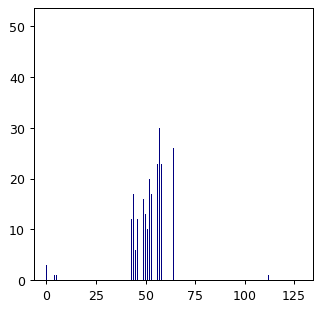

In [24]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

plt.figure(figsize=(4,4), dpi=90)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.show()

0
1
2
3
4
5
6
7


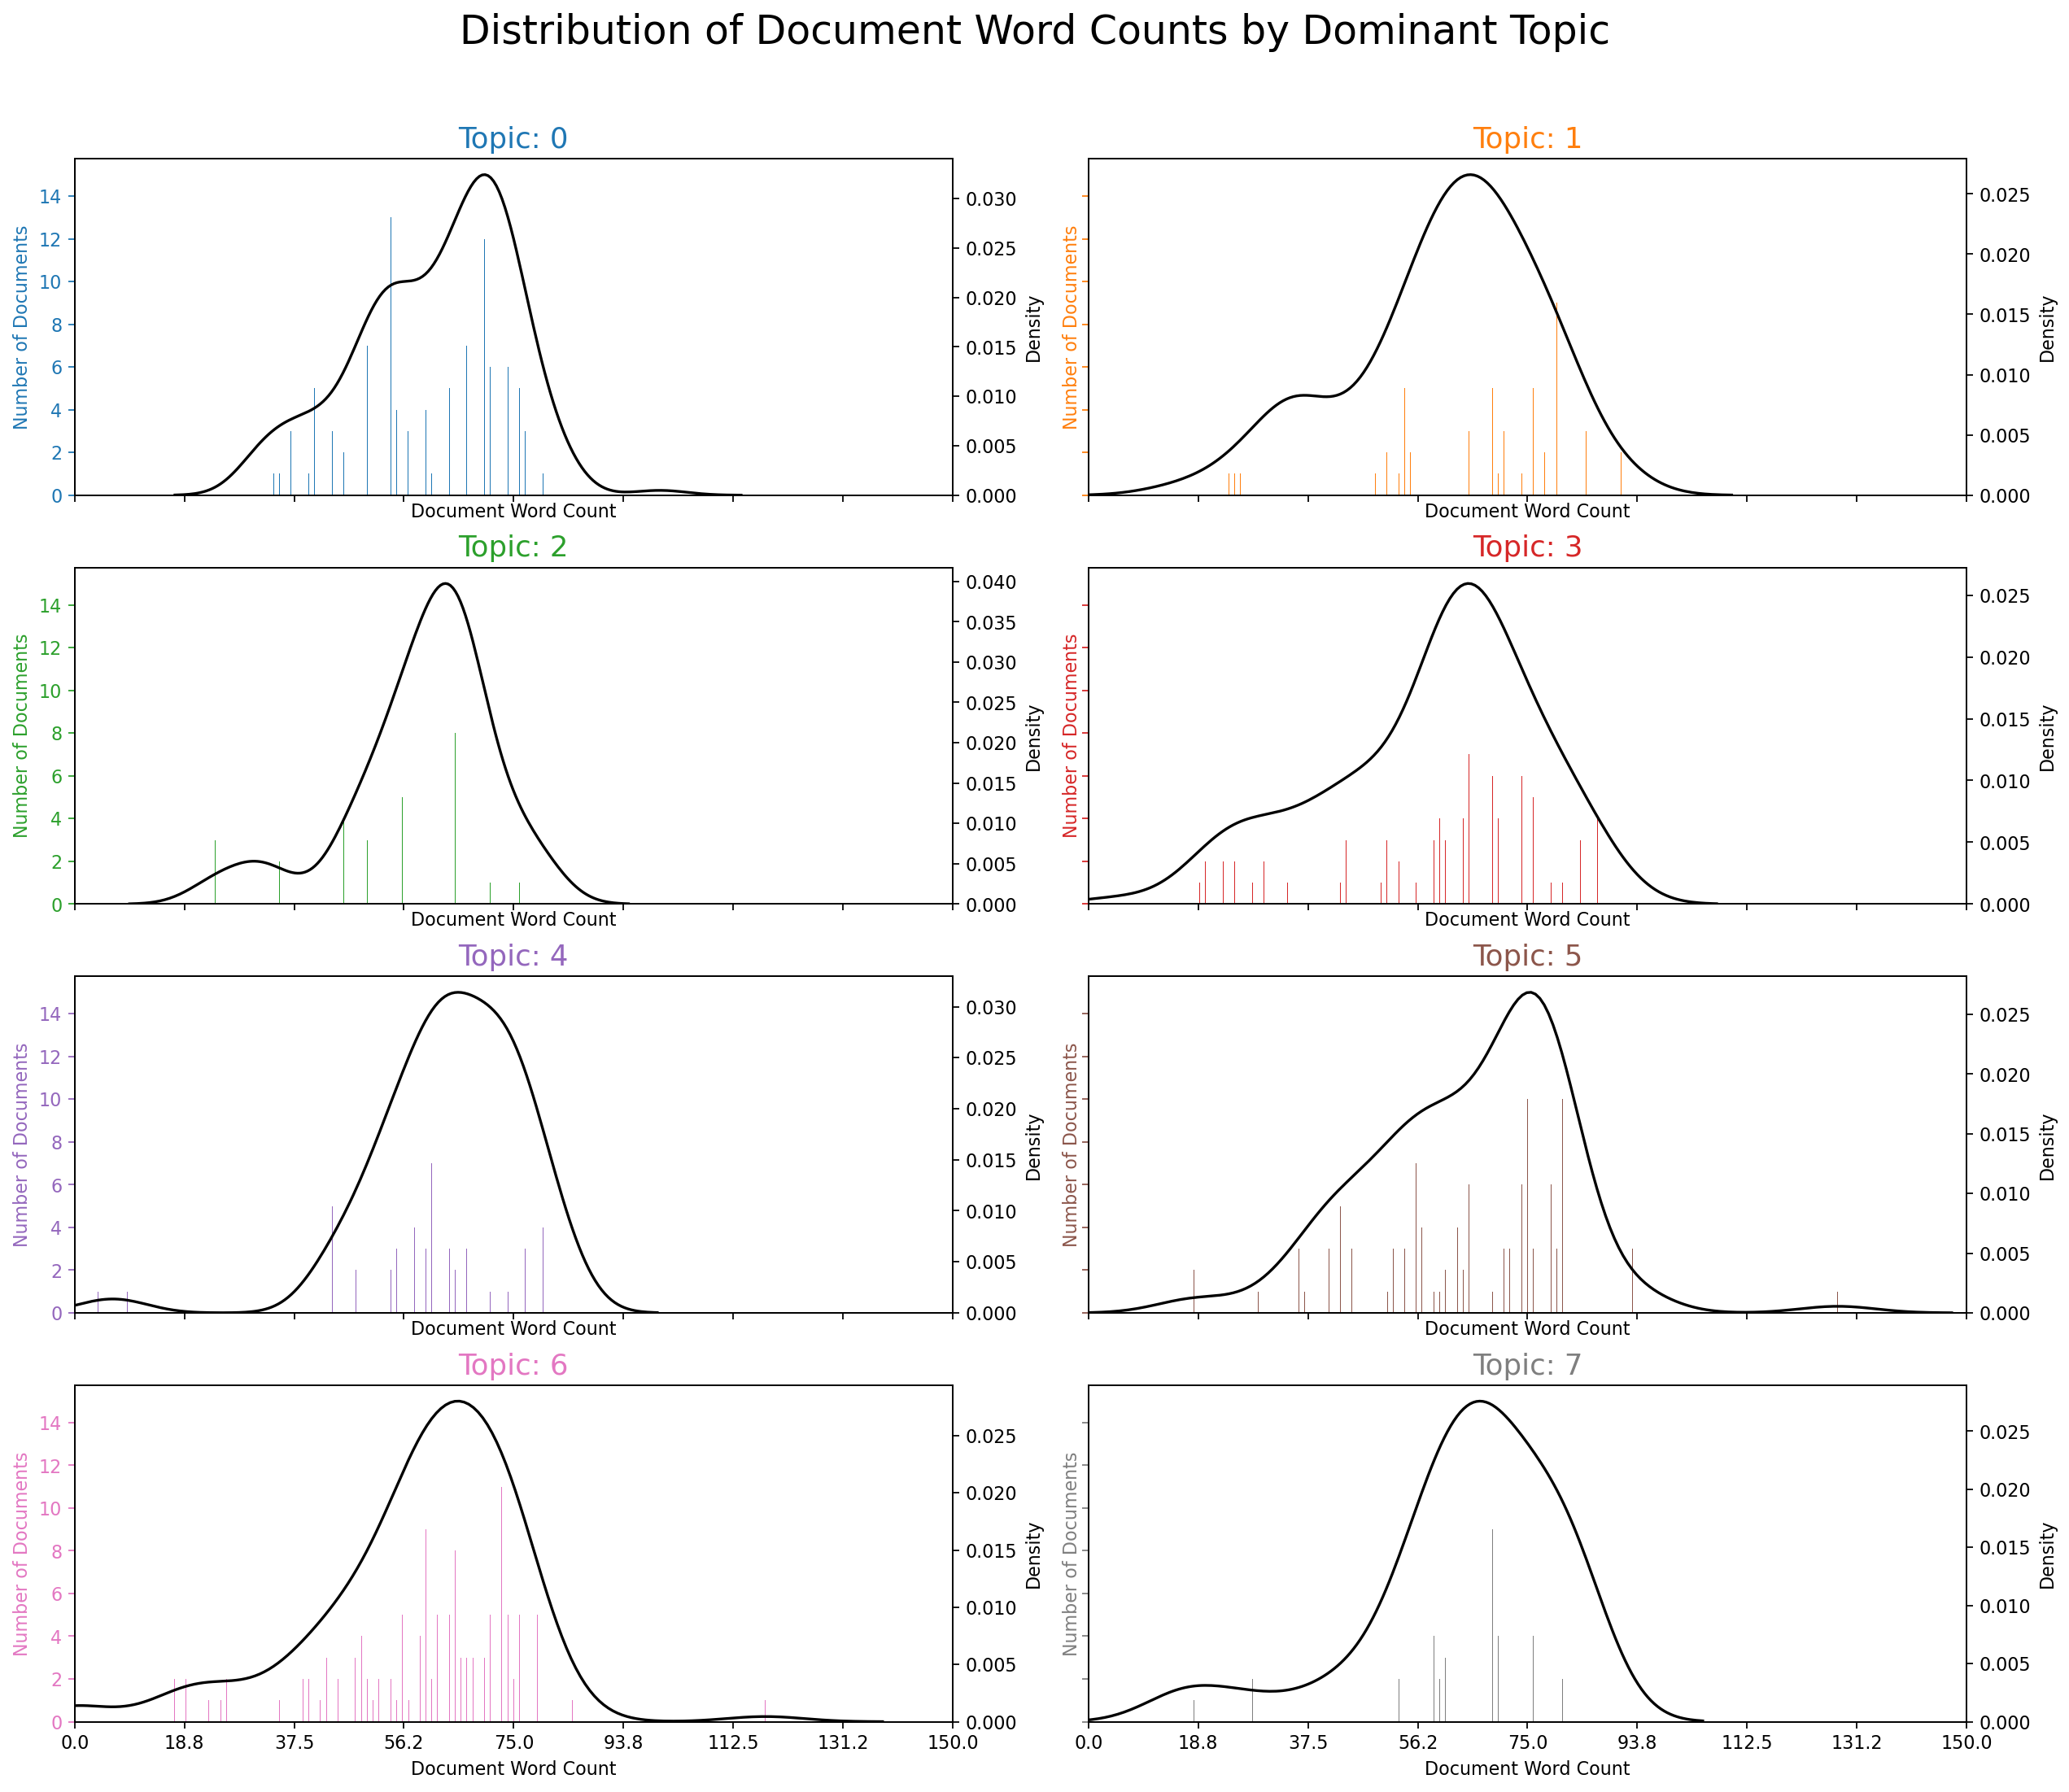

In [25]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(4,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    print(i)
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 150), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,150,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

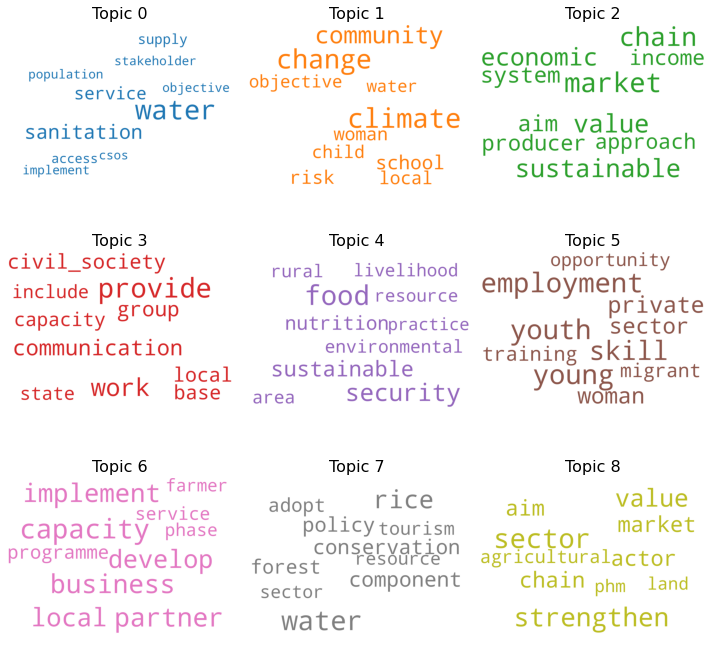

In [26]:
# 1. Wordcloud of Top N words in each topic
# python -m pip install wordcloud
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

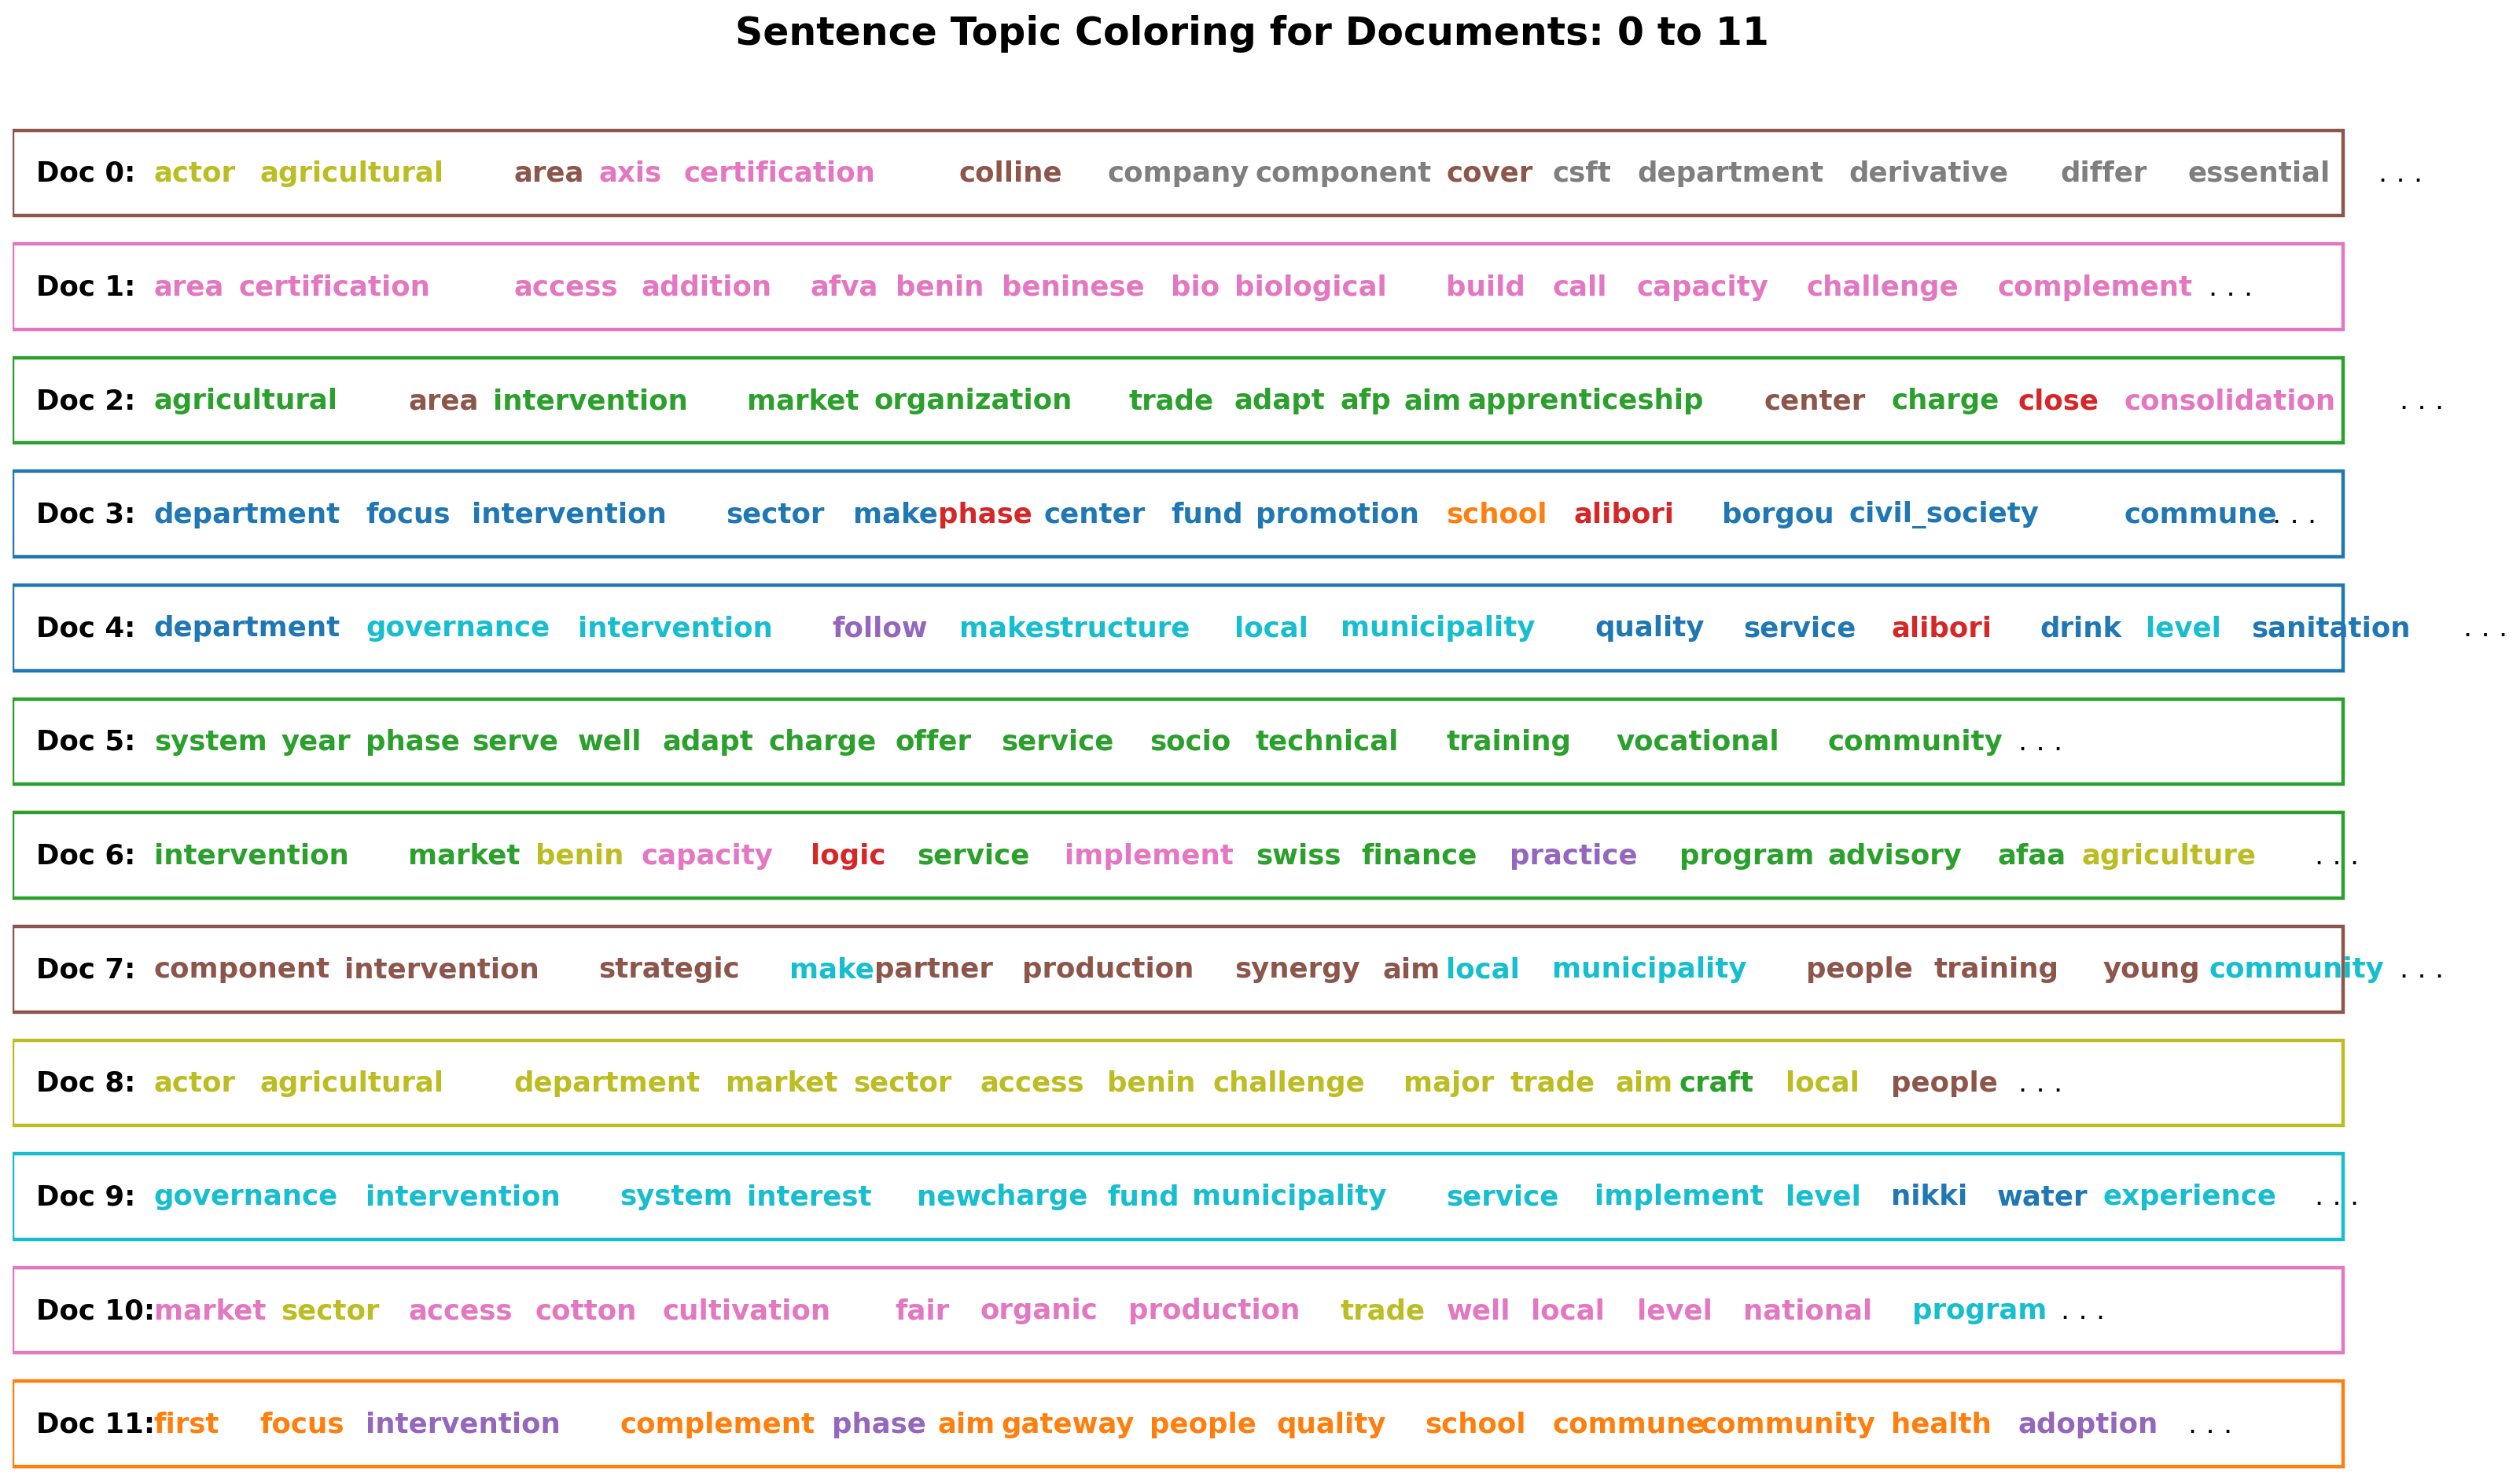

In [27]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()    

In [28]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

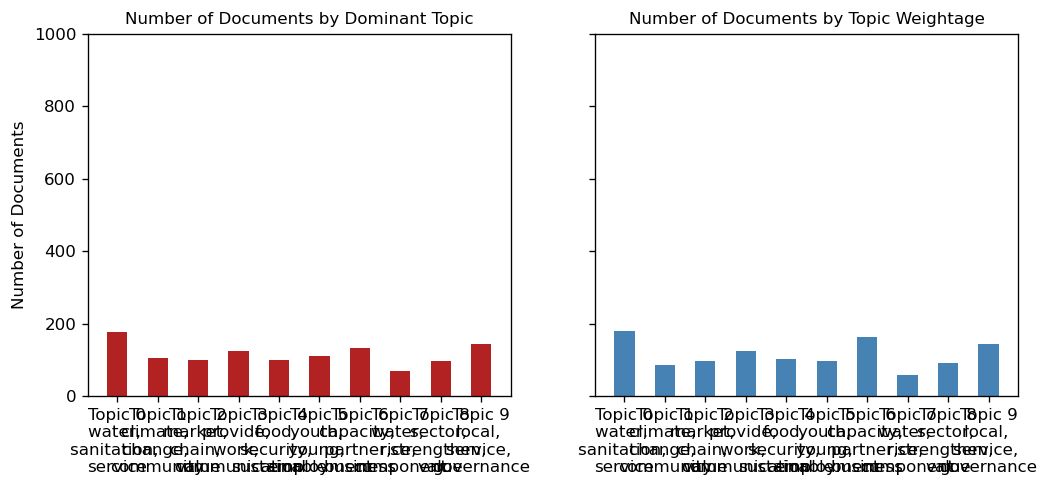

In [29]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [30]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 8
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 978 samples in 0.002s...
[t-SNE] Computed neighbors for 978 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 978 / 978
[t-SNE] Mean sigma: 0.045038
[t-SNE] KL divergence after 250 iterations with early exaggeration: 55.006039
[t-SNE] KL divergence after 1000 iterations: 0.352051


Loading BokehJS ...

In [31]:
def convert_to_string(x):
    single_string = ""
    for element in x:
        single_string += ' ' + element
    return  single_string
        
#data_lemmatized.apply(lambda x: convert_to_string(x))

data_lemmatized2 = data_lemmatized[0 : 1000]

l = []
for element in data_lemmatized2 :
    l.append(convert_to_string(element))


In [32]:
print(data_lemmatized[0])
print(l[0])

['agricultural', 'actor', 'differ', 'profa', 'strategic', 'orientation', 'focus', 'component', 'certification', 'participatory', 'guarantee', 'system', 'spg', 'governance', 'agricultural', 'sector', 'lever', 'actor', 'remain', 'essential', 'survival', 'family', 'farming', 'thus', 'cover', 'period', 'period', 'year', 'intervention', 'cover', 'first', 'area', 'market', 'garden', 'second', 'axis', 'colline', 'department', 'work', 'agricultural', 'orientation', 'law', 'synpa', 'company', 'csft', 'promo', 'fruit', 'et', 'fruit', 'tillou', 'pineapple', 'derivative']
 agricultural actor differ profa strategic orientation focus component certification participatory guarantee system spg governance agricultural sector lever actor remain essential survival family farming thus cover period period year intervention cover first area market garden second axis colline department work agricultural orientation law synpa company csft promo fruit et fruit tillou pineapple derivative


In [33]:
print(l)

[' agricultural actor differ profa strategic orientation focus component certification participatory guarantee system spg governance agricultural sector lever actor remain essential survival family farming thus cover period period year intervention cover first area market garden second axis colline department work agricultural orientation law synpa company csft promo fruit et fruit tillou pineapple derivative', ' bio cotton organic fair trade crop protect area follow phase context beninese government sonapra take interest cultivation organic cotton synergy effort make uavigref afva well producer partner favor structure result umbrella call producteur trice biological culture benin complement capacity build new umbrella organization grassroot cooperative play role serve member particular wear organic fair trade certification access factor production addition major challenge help create condition profitability', ' vocational training afp part logic local economy deprive area promotion cl

In [34]:
df = pd.read_excel("/Users/tomhaidinger/Desktop/outputDataHelvetas.xlsx")

df2 = df.loc[0:999, "Project WF"]
df2_list = list(df2)

In [35]:
len(df2_list) == len(l)


True

In [36]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(l, df2_list, test_size=0.33, random_state=42)
print(X_test)
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

#vectorizer.get_feature_names_out()



[' climate change adaptation disaster risk cca cross_cut theme entire nepal country program anchor theme country program activity ensure lesson_learn analyze share develop action innovative way promote nepal highly prone disaster addition lie high earthquake risk zone climate change bring heighted risk abnormal weather event lead storm flood drought primary stakeholder woman disadvantage group high risk select local government identify impact climate change promote adaptation activity time develop drm plan special provision vulnerable citizen', ' governance peace consider crucial work area cross_cut theme current country strategy working area good governance programme mainly focus woman man especially economically poor socially marginalise primary stakeholder right_holder contribute establish effective transparent_accountable institution different level ensure inclusive responsive decision make programme available input carry activity result effective engagement right_holder local gove

In [37]:
#X_test

In [38]:
from sklearn.svm import LinearSVC

clf = LinearSVC()
clf.fit(X_train, y_train)

LinearSVC()

In [39]:
pred = clf.predict(X_test)

In [40]:
target_names2 = ['BAR - Bridges and Roads',
 'BED - Basic Education',
 'CDR - Climate and Disaster Resilience',
 'CTR - Conflict Transformation',
 'FAN - Food and Nutrition',
 'GCS - Governance and Civic Spaces',
 'MIG - Migration',
 'PSD - Private Sector Development',
 'SMA - Small Mandates',
 'VSD - Vocational Skills',
 'WSG - WASH and Water Governance']
#target_names = set(y_train)
#pprint(target_names2)

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred, target_names=target_names2))

                                       precision    recall  f1-score   support

              BAR - Bridges and Roads       1.00      1.00      1.00         9
                BED - Basic Education       0.80      1.00      0.89         8
CDR - Climate and Disaster Resilience       0.89      0.96      0.92        56
        CTR - Conflict Transformation       1.00      0.74      0.85        19
             FAN - Food and Nutrition       0.79      0.88      0.83        42
    GCS - Governance and Civic Spaces       0.87      0.92      0.90        51
                      MIG - Migration       1.00      0.86      0.92         7
     PSD - Private Sector Development       0.88      0.84      0.86        45
                 SMA - Small Mandates       0.96      0.87      0.92        31
              VSD - Vocational Skills       0.95      0.92      0.93        59
      WSG - WASH and Water Governance       1.00      0.33      0.50         3

                             accuracy             

In [42]:
test_list = ['The project supports understanding and conservation of local sites that are of cultural and historical interest through archaeology The involvement of communities in these processes is promoted for ownership as resource persons and for sustainable management of sites that are excavated. The wider implication is that it leads to strengthening of community roles and responsibilities over local heritage and local development.The documentation of archaeological findings and their professional presentation will also lead to economic benefits for rural communities. It is expected that doors will open to new sources of income through well thought through sustainable tourism. The archaeological works are carried out jointly by experts from Switzerland and partners in Bhutan, so that knowledge and skill transfers take place. The increased interest and capacities in archaeology in the partner department and among culture officers in partner districts are concrete outputs.']
test_list_vec = vectorizer.transform(test_list)

In [43]:
pred2 = clf.predict(test_list_vec)
print(pred2)

['CTR - Conflict Transformation']


In [44]:
df2_list

['PSD - Private Sector Development',
 'PSD - Private Sector Development',
 'VSD - Vocational Skills',
 'WSG - WASH and Water Governance',
 'WSG - WASH and Water Governance',
 'BED - Basic Education',
 'FAN - Food and Nutrition',
 'MIG - Migration',
 'VSD - Vocational Skills',
 'BAR - Bridges and Roads',
 'PSD - Private Sector Development',
 'WSG - WASH and Water Governance',
 'VSD - Vocational Skills',
 'WSG - WASH and Water Governance',
 'BAR - Bridges and Roads',
 'BAR - Bridges and Roads',
 'WSG - WASH and Water Governance',
 'WSG - WASH and Water Governance',
 'GCS - Governance and Civic Spaces',
 'BAR - Bridges and Roads',
 'CDR - Climate and Disaster Resilience',
 'GCS - Governance and Civic Spaces',
 'VSD - Vocational Skills',
 'WSG - WASH and Water Governance',
 'WSG - WASH and Water Governance',
 'CDR - Climate and Disaster Resilience',
 'CDR - Climate and Disaster Resilience',
 'CDR - Climate and Disaster Resilience',
 'WSG - WASH and Water Governance',
 'CDR - Climate and Di

data_raw['category'].value_counts()


In [45]:
#!python -m spacy download 'en_core_web_lg'

In [46]:
#set(df2_list)

In [47]:
test = ['Bridges Roads', 'Basic Education', 'Climate Disaster Resilience', 'Conflict Transformation', 'Food and Nutrition', 'Governance and Civic Spaces', 'Migration', 'Private Sector Development', 'Small Mandates', 'Vocational Skills', ' Water Governance']

In [48]:
#from models import EmbeddingClassifier
#print(test)
#model = EmbeddingClassifier(test)

#X_train, X_test, y_train, y_test = train_test_split(l, df2_list, test_size=0.25, random_state=42)

#for element in X_test:
#    print(model.predict(element))



#model.predict(X_test[0].split(" "))

In [49]:
print(type(data_lemmatized2[0]))

<class 'list'>


/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in fav